In [4]:
#Notebook for prototyping traffic forecasting models
#Requires   raw hourly time series ex. data 2019-2020_nodes.csv
#           weather-2019.csv
#           crash_data.csv
import pandas as pd
import numpy as np
from datetime import datetime
from fbprophet import Prophet
from matplotlib import pyplot as plt
import os
%matplotlib inline 

#df = pd.read_csv("sample_data/2019-2020_1000.csv",header=None)
#df = pd.read_csv("sample_data/2019-2020_100.csv",header=None)
df = pd.read_csv("sample_data/2019-2020_nodes.csv",header=None)


In [5]:
#df = df[:200]

In [9]:
#datetime_object = datetime.strptime('01/01/2019', '%b/%d/%Y')
crash_df = pd.read_csv("sample_data/crash_data.csv")

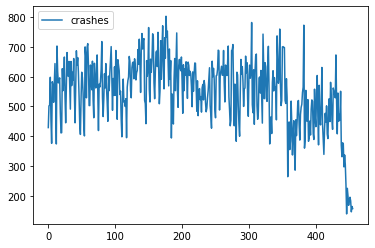

In [ ]:
crash_df.plot()

In [10]:
def RMSE(test_vals):
  loss = (test_vals["yhat"]-test_vals["y"])**2
  RMSE = np.sqrt(np.sum(loss.values))
  return RMSE

In [11]:
def model_baseline(index,growth,seasonality_mode,regressor_mode, directory):
  time_series1 = df.iloc[index].values[1:8761]
  time_series2 = df.iloc[index].values[8765:-4]
  end_id = df.iloc[index].values[-3]
  start_id = df.iloc[index].values[-2]
  street_id = df.iloc[index].values[-1]
  y = np.concatenate((time_series1,time_series2))
  ds = pd.date_range('2019-01-01','2020-04-01',freq='1H',closed='left',tz='US/Eastern')
  ds = np.array([ds[i].replace(tzinfo=None) for i in range(len(ds))])
  #street_id = np.array([street_id for _ in range(len(y))])
  formatted_df = pd.DataFrame(data=[ds,y]).T
  formatted_df.columns = ["ds","y"]
  formatted_df = formatted_df.set_index(pd.DatetimeIndex(formatted_df["ds"]))
  daily_average = formatted_df[["y"]].astype(np.double).resample("D").mean()
  train_ind = 365  
  train_df = daily_average[:train_ind]
  ts = train_df["y"].values
  CV = np.std(ts)/np.mean(ts)
  print(CV)
  if CV < 0.01:
    return -1,-1
  test_df = daily_average[train_ind:]
  train_df["ds"] = train_df.index
  
  model = Prophet(growth=growth,interval_width = 0.95,weekly_seasonality=True,yearly_seasonality=True,seasonality_mode = seasonality_mode) 
  model.fit(train_df)
  future_pd = model.make_future_dataframe(periods=len(test_df), freq='d') 
  forecast_pd = model.predict(future_pd)    
  forecast_pd = forecast_pd.set_index("ds")
  forecast_pd.insert(0,"ds",forecast_pd.index)
  model.plot_components(forecast_pd).savefig(directory+"/"+str(index)+"A_model_components.png") 
  plt.show()
  target = pd.merge(daily_average, forecast_pd, how='outer', left_index=True, right_index=True)
  test_vals = target[["yhat","y"]][train_ind:-1]
  error = RMSE(test_vals)
  plt.plot(target[["y","yhat"]][:train_ind])
  plt.plot(target[["y","yhat"]][train_ind:])
  plt.savefig(directory + "/" + str(index) + "A_plot.png")
  plt.show()
  return error,target[["y","yhat"]][train_ind:]

In [ ]:
weather_headers = ['ds', 'temp','precipitation', 'visibility','wind_gust', 'wind_speed', 'rain', 'snow', 'mist', 'fog', 'haze', 'freezing']
weather_df = pd.read_csv("sample_data/weather-2019.csv", header=None, names=weather_headers, parse_dates=['ds'])  
weather_df = weather_df.fillna(method="pad")
weather_df= weather_df.set_index(pd.DatetimeIndex(weather_df["ds"]))

In [ ]:
def model_weather(index,growth,seasonality_mode, regressor_mode,directory):
  time_series1 = df.iloc[index].values[1:8761]
  time_series2 = df.iloc[index].values[8765:-4]
  end_id = df.iloc[index].values[-3]
  start_id = df.iloc[index].values[-2]
  street_id = df.iloc[index].values[-1]
  y = np.concatenate((time_series1,time_series2))
  ds = pd.date_range('2019-01-01','2020-04-01',freq='1H',closed='left',tz='US/Eastern')
  ds = np.array([ds[i].replace(tzinfo=None) for i in range(len(ds))])
  formatted_df = pd.DataFrame(data=[ds,y]).T
  formatted_df.columns = ["ds","y"]
  train_ind = 365
  formatted_df = formatted_df.set_index(pd.DatetimeIndex(formatted_df["ds"]))
  daily_average = formatted_df[["y"]].astype(np.double).resample("D").mean()

  column_set = ["visibility","rain","snow","freezing"]
  weather_df_average = weather_df[column_set].resample("D").max()
  left = len(daily_average) - 365
  weather_df_average = weather_df_average.append(weather_df_average[:left])
  weather_df_average = weather_df_average.set_index(daily_average.index)
  weather_score = weather_df_average.sum(axis=1).values
  train_df = daily_average[:train_ind]
  train_df.insert(0,"ds",train_df.index)
  #train_df.insert(0,"weather",weather_score[:train_ind])
  train_df.insert(0,"rain",weather_df_average["rain"].values[:train_ind])
  train_df.insert(0,"snow",weather_df_average["snow"].values[:train_ind])
  train_df.insert(0,"freezing",weather_df_average["freezing"].values[:train_ind])
  train_df.insert(0,"visibility",weather_df_average["visibility"].values[:train_ind])
  train_df.insert(0,"crashes",crash_df["crashes"].values[:train_ind])
  test_df = daily_average[train_ind:]
  test_df.insert(0,"ds",test_df.index)  
  #test_df.insert(0,"weather",weather_score[train_ind:])   
  test_df.insert(0,"rain",weather_df_average["rain"].values[train_ind:])
  test_df.insert(0,"snow",weather_df_average["snow"].values[train_ind:])
  test_df.insert(0,"freezing",weather_df_average["freezing"].values[train_ind:])
  test_df.insert(0,"visibility",weather_df_average["visibility"].values[train_ind:])
  test_df.insert(0,"crashes",crash_df["crashes"].values[train_ind:])
  print(test_df.head())
  ts = train_df["y"].values
  CV = np.std(ts)/np.mean(ts)
  if CV < 0.01:
    return -1,-1
  model = Prophet(growth=growth,interval_width = 0.95,weekly_seasonality=True,yearly_seasonality=True,seasonality_mode = seasonality_mode)
  for col in weather_df_average.columns:
    if col == "temp":
      continue
    #model.add_regressor(col,prior_scale=1,mode="multiplicative")
  #model.add_regressor("weather",mode="additive")
  model.add_regressor("rain",mode=regressor_mode)
  model.add_regressor("snow",mode=regressor_mode)
  model.add_regressor("freezing",mode=regressor_mode)
  model.add_regressor("visibility",mode=regressor_mode)
  model.add_regressor("crashes",mode=regressor_mode)
  model.fit(train_df)
  print("fitted")
  #future_pd = model.make_future_dataframe(periods=len(test_df), freq='d') 
  #future_pd.insert(1,"temp",daily_average_temp_total)
  future_pd = train_df.append(test_df)
  future_pd["ds"] = daily_average.index
  #future_pd = future_pd.set_index("ds")
  forecast_pd = model.predict(future_pd)
  forecast_pd = forecast_pd.set_index("ds")
  forecast_pd["ds"] = forecast_pd.index
  model.plot_components(forecast_pd).savefig(directory+"/"+str(index)+"B_model_components.png")
  plt.show()  
  target = pd.merge(daily_average, forecast_pd, how='outer', left_index=True, right_index=True)
  test_vals = target[["yhat","y"]][train_ind:-1]
  error = RMSE(test_vals)
  plt.plot(target[["y","yhat"]][:train_ind])
  plt.plot(target[["y","yhat"]][train_ind:])
  plt.savefig(directory + "/" + str(index) + "B_plot.png")
  plt.show()
  return error, target[["y","yhat"]][train_ind:]

In [ ]:
!rm -r sample_data/output

rm: cannot remove 'sample_data/output': No such file or directory


In [ ]:
growth_params = ['linear']
seasonality_modes = ['additive','multiplicative']
regressor_modes = ['additive','multiplicative']


In [ ]:
#These are our tuned hyperparameters
growth_params = ['linear']
seasonality_modes = ['multiplicative']
regressor_modes = ['multiplicative']

In [ ]:
if not os.path.isdir("sample_data/output"):
  os.mkdir("sample_data/output")

In [ ]:
for growth_p in growth_params:
  for seasonality_p in seasonality_modes:
    for regressor_p in regressor_modes:
      param_set = [growth_p,seasonality_p,regressor_p]
      print(param_set)
      param_directory = "sample_data/output/" + "_".join(param_set)   
      if not os.path.isdir(param_directory):
        os.mkdir(param_directory)
      model_a = []
      model_b = []
      for index in range(len(df)):
        out = model_baseline(index,growth=growth_p,seasonality_mode = seasonality_p, regressor_mode = regressor_p,directory= param_directory)
        if out[0] == -1:
          continue
        model_a.append(out)
        out = model_weather(index,growth=growth_p,seasonality_mode = seasonality_p, regressor_mode = regressor_p,directory=param_directory)
        model_b.append(out)
      errors_1 = [b[0] for b in model_a]
      errors_2 = [b[0] for b in model_b]
      avg_error1 = np.mean(errors_1)
      avg_error2 = np.mean(errors_2)
      print(avg_error1, avg_error2)
      file = open(param_directory+"/loss","w+")
      file.write(str((avg_error1,avg_error2)))
      file.close()




In [ ]:
errors_1 = [b[0] for b in model_a]
errors_2 = [b[0] for b in model_b]
avg_error1 = np.mean(errors_1)
avg_error2 = np.mean(errors_2)
print(avg_error1, avg_error2)


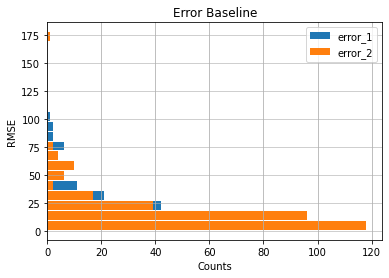

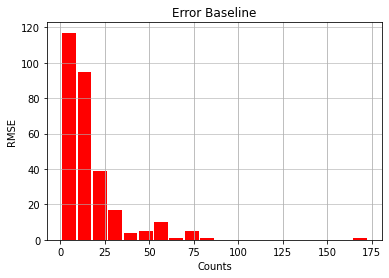

In [ ]:
errors = pd.DataFrame(data=[errors_1,errors_2]).T
errors.columns=["error_1","error_2"]
errors.plot.hist(histtype='bar',grid=True, bins=20, rwidth=0.9,orientation='horizontal'
                  )
plt.title('Error Baseline')
plt.xlabel('Counts')
plt.ylabel('RMSE')
plt.grid(axis='y', alpha=0.75)

plt.show()
errors["error_2"].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='r')

plt.title('Error Baseline')
plt.xlabel('Counts')
plt.ylabel('RMSE')
plt.grid(axis='y', alpha=0.75)
plt.show()
